In [1]:
%matplotlib inline

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from data_generators import *
import glob
import cv2
import pickle
import h5py
import pandas as pd
from sklearn.model_selection import train_test_split


import tensorflow as tf
from tensorflow.python.client import device_lib

from keras.models import Sequential, load_model
from keras.layers.convolutional import Convolution2D, Convolution3D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda, SpatialDropout2D
from keras.layers import Conv2D, ELU, Conv3D, MaxPooling2D
from keras.optimizers import rmsprop, Adam
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.regularizers import l2
from keras.engine.topology import Layer

# SpatialDropout2D <==> data_format='channels_last'

Using TensorFlow backend.


In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15307720015515923969, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11323454260
 locality {
   bus_id: 1
 }
 incarnation: 15870071728489626574
 physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:03:00.0, compute capability: 3.5"]

In [7]:
# BATCH_SIZE, ROWS, COLS, CHANNELS = 32, 480, 640, 5
# BATCH_SIZE, ROWS, COLS, CHANNELS = 32, 480, 640, 3
BATCH_SIZE, ROWS, COLS, CHANNELS = 32, 480, 640, 2

#inspired in https://images.nvidia.com/content/tegra/automotive/images/2016/solutions/pdf/end-to-end-dl-using-px.pdf
#https://medium.com/weightsandbiases/predicting-vehicle-speed-from-dashcam-video-f6158054f6fd
class Residual(Layer):
    def __init__(self, channels_in, kernel,**kwargs):
        super(Residual, self).__init__(**kwargs)
        self.channels_in = channels_in
        self.kernel = kernel

    def call(self, x):
        # the residual block using Keras functional API
        first_layer =   Activation("linear", trainable=False)(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(first_layer)
        x =             Activation("elu")(x)
        x =             Conv2D( self.channels_in,
                                self.kernel,
                                padding="same")(x)
        residual =      Add()([x, first_layer])
        x =             Activation("elu")(residual)
        return x

    def compute_output_shape(self, input_shape):
        return input_shape

def cnn_model():
    kernel_init='lecun_normal'
    initializer='he_normal'
    in_shape = (ROWS, COLS, CHANNELS)
    
    model = Sequential()
    model.add(Conv2D(32, (7, 7), padding='valid', 
                 kernel_initializer=kernel_init,
#                  kernel_regularizer=l2(1e-4),
                 strides=(3,3), input_shape=in_shape)
    )
    model.add(ELU())
    
    
    model.add(Conv2D(48, (7, 7), padding='valid', 
                     kernel_initializer=kernel_init,
#                      kernel_regularizer=l2(1e-4),
                     strides=(3,3))
    )
    model.add(ELU())
    
    model.add(SpatialDropout2D(0.5))
    
    model.add(Conv2D(64, (5, 5), padding='valid', 
                     kernel_initializer=kernel_init,
#                      kernel_regularizer=l2(1e-4),
                     strides=(2,2))
    )
    model.add(ELU())

#     Residual(32, (7, 7), 
#         kernel_initializer=kernel_init, 
#         kernel_regularizer=l2(1e-4),
#         input_shape=in_shape
#     )

#     Residual(64, (5, 5),
# #         kernel_initializer=kernel_init, 
# #         kernel_regularizer=l2(1e-4),
#     )
    
#     model.add(SpatialDropout2D(0.5))
    
#     Residual(64, (3, 3),
# #         kernel_initializer=kernel_init, 
# #         kernel_regularizer=l2(1e-4),
#     )
    
    model.add(Conv2D(64, (5, 5), padding='valid', 
                     kernel_initializer=kernel_init,
#                      kernel_regularizer=l2(1e-4),
                     strides=(2,2))
    )
    model.add(ELU())

# #     model.add(SpatialDropout2D(0.5))
    
    model.add(Conv2D(128, (3, 3), padding='valid', 
                     kernel_initializer=kernel_init,
#                      kernel_regularizer=l2(1e-4),
                     strides=(2,2))
    )
    model.add(ELU())
    
    
    
    model.add(Flatten())
    
    model.add(Dense(256, kernel_initializer=initializer))
    model.add(ELU())
    
#     model.add(Dropout(0.5))

    model.add(Dense(128, kernel_initializer=initializer))
    model.add(ELU())
    
#     model.add(Dropout(0.5))

    model.add(Dense(64, kernel_initializer=initializer))
    model.add(ELU())
    
    model.add(Dropout(0.5))

    model.add(Dense(32, kernel_initializer=initializer))
    model.add(ELU())

    model.add(Dense(1, kernel_initializer=initializer))

    
    return model

In [8]:
# model = cnn_model()
# for layer in model.layers:
#     print(layer.output_shape)

In [ ]:
train_files = []
train_data = []
valid_data = []
test_data = []

output_dir = 'training_output'
os.makedirs(output_dir, exist_ok=True)
epochs = 1000

# for thresh in [1.11, 0.05, 0.10, 0.15, 0.20]:
# for thresh in [0.05, 0.10, 0.15, 0.20, 1.11]:
for thresh in [0.10, 0.20]:
    for sample_i in range(1):
        suffix = "%03dp"%(np.round(100.0*thresh))
        train_files[:] = sorted(glob.glob('./train_%s/*.npz'%suffix))
        total_n_train = len(train_files)
        fsuffix = "%s_-_%02d_-_epochs_%04d"%(suffix, sample_i, epochs)
        print(fsuffix)
        # test_files = sorted(glob.glob('./test/*.npz'))
        
        model_fname = os.path.join(output_dir, 'speed_test_model_%s.h5'%fsuffix)
        if os.path.isfile(model_fname):
            continue
            
        n_train, n_valid, n_test = int(0.8*total_n_train), int(0.19*total_n_train), int(0.01*total_n_train)

        print(n_train, n_valid, n_test)
        if bool(0):
            train_steps = 200
            valid_steps = 20
            test_steps = 20
        else:
            train_steps = int(np.ceil(float(n_train) / float(BATCH_SIZE)))
            valid_steps = int(np.ceil(float(n_valid) / float(BATCH_SIZE)))
            test_steps = int(np.ceil(float(n_test) / float(BATCH_SIZE)))

        train_ids = np.random.choice(total_n_train, size=n_train, replace=False)
        avail_ids = np.setdiff1d(np.arange(total_n_train), train_ids)
        test_ids = np.random.choice(avail_ids, size=n_test, replace=False)
        valid_ids = np.setdiff1d(avail_ids, test_ids)

        train_data[:] = [train_files[i] for i in train_ids]
        valid_data[:] = [train_files[i] for i in valid_ids]
        test_data[:] = [train_files[i] for i in test_ids]

        train_gen = train_generator(train_data, BATCH_SIZE)
        valid_gen = train_generator(valid_data, BATCH_SIZE)
        test_gen = train_generator(test_data, BATCH_SIZE)

        model = cnn_model()

        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

        model_fname = os.path.join(output_dir, 'best_val_model_%s.h5'%fsuffix)
        mc = ModelCheckpoint(model_fname, monitor='val_loss', 
                             mode='min', save_best_only=True)

        model_fname = os.path.join(output_dir, 'best_train_model_%s.h5'%fsuffix)
        mc = ModelCheckpoint(model_fname, monitor='loss', 
                             mode='min', save_best_only=True)

#         optimizer = rmsprop(lr=0.00001)
        optimizer = Adam(
            lr=0.000001, 
        #         beta_1=0.9, 
        #         beta_2=0.999, 
        #         epsilon=None, 
        #         decay=0.0, 
#             amsgrad=bool(1)
        )

        model.compile(optimizer=optimizer, loss='mse')

        # test_gen = test_generator(test_files, BATCH_SIZE)

        fit_log = model.fit_generator(
            train_gen, 
            steps_per_epoch=train_steps, 
            validation_data=valid_gen,
            validation_steps=valid_steps,
            epochs=epochs,
            verbose=1,
            shuffle=True,
        )

        history_fname = os.path.join(output_dir, 'train_history_dict_%s.pickle'%fsuffix)
        with open(history_fname, 'wb') as file_pi:
                pickle.dump(fit_log.history, file_pi)


        model_fname = os.path.join(output_dir, 'speed_test_model_%s.h5'%fsuffix)
        model.save(model_fname)

        fig = plt.figure()
        ax = plt.subplot(1, 1, 1)
        plt.plot(fit_log.history['loss'], label='train loss')
        plt.plot(fit_log.history['val_loss'], label='validation loss')
        plt.legend()
        plt.savefig(os.path.join(output_dir, "loss_behaviour_%s.pdf"%fsuffix))
        plt.show()

        #scores = model.evaluate()

010p_-_00_-_epochs_1000
16319 3875 203
Epoch 1/1000
510/510 [==============================] - 516s 1s/step - loss: 209.9801 - val_loss: 206.2988
Epoch 2/1000
510/510 [==============================] - 497s 975ms/step - loss: 172.9688 - val_loss: 124.8804
Epoch 3/1000
510/510 [==============================] - 496s 972ms/step - loss: 92.6487 - val_loss: 71.4289
Epoch 4/1000
510/510 [==============================] - 497s 974ms/step - loss: 76.7655 - val_loss: 68.0936
Epoch 5/1000
510/510 [==============================] - 502s 985ms/step - loss: 73.7084 - val_loss: 66.1478
Epoch 6/1000
510/510 [==============================] - 503s 986ms/step - loss: 69.5513 - val_loss: 61.0602
Epoch 7/1000
510/510 [==============================] - 512s 1s/step - loss: 66.8977 - val_loss: 60.2351
Epoch 8/1000
510/510 [==============================] - 507s 994ms/step - loss: 64.2638 - val_loss: 58.2146
Epoch 9/1000
510/510 [==============================] - 510s 1000ms/step - loss: 61.8999 - val_loss

Epoch 76/1000
510/510 [==============================] - 495s 971ms/step - loss: 20.3464 - val_loss: 19.1830
Epoch 77/1000
510/510 [==============================] - 494s 969ms/step - loss: 19.9065 - val_loss: 16.4260
Epoch 78/1000
510/510 [==============================] - 495s 971ms/step - loss: 19.2647 - val_loss: 16.9397
Epoch 79/1000
510/510 [==============================] - 494s 968ms/step - loss: 19.2229 - val_loss: 17.2645
Epoch 80/1000
510/510 [==============================] - 494s 969ms/step - loss: 19.6036 - val_loss: 16.0566
Epoch 81/1000
510/510 [==============================] - 495s 970ms/step - loss: 19.3568 - val_loss: 17.3330
Epoch 82/1000
510/510 [==============================] - 496s 973ms/step - loss: 18.9381 - val_loss: 15.8462
Epoch 83/1000
510/510 [==============================] - 497s 974ms/step - loss: 18.9136 - val_loss: 15.2480
Epoch 84/1000
510/510 [==============================] - 496s 973ms/step - loss: 19.0471 - val_loss: 16.9358
Epoch 85/1000
510/5

510/510 [==============================] - 495s 970ms/step - loss: 13.6500 - val_loss: 11.5548
Epoch 151/1000
510/510 [==============================] - 496s 972ms/step - loss: 13.6394 - val_loss: 12.0569
Epoch 152/1000
510/510 [==============================] - 496s 973ms/step - loss: 13.6897 - val_loss: 13.0673
Epoch 153/1000
510/510 [==============================] - 497s 975ms/step - loss: 13.5304 - val_loss: 12.0864
Epoch 154/1000
142/510 [=======>......................] - ETA: 4:37 - loss: 12.5981

In [ ]:
thresh = 0.05
suffix = "%03dp"%(np.round(100.0*thresh))
train_files[:] = sorted(glob.glob('./train_%s/*.npz'%suffix))
total_n_train = len(train_files)
sample_i = 0
n_epochs = 200
fsuffix = "%s_-_%02d_%04d"%(suffix, sample_i, n_epochs)
print(fsuffix)
# test_files = sorted(glob.glob('./test/*.npz'))

n_train, n_valid, n_test = int(0.8*total_n_train), int(0.19*total_n_train), int(0.01*total_n_train)

print(n_train, n_valid, n_test)
train_steps = int(np.ceil(float(n_train) / float(BATCH_SIZE)))
valid_steps = int(np.ceil(float(n_valid) / float(BATCH_SIZE)))
test_steps = int(np.ceil(float(n_test) / float(BATCH_SIZE)))

train_ids = np.random.choice(total_n_train, size=n_train, replace=False)
avail_ids = np.setdiff1d(np.arange(total_n_train), train_ids)
test_ids = np.random.choice(avail_ids, size=n_test, replace=False)
valid_ids = np.setdiff1d(avail_ids, test_ids)

train_data[:] = [train_files[i] for i in train_ids]
valid_data[:] = [train_files[i] for i in valid_ids]
test_data[:] = [train_files[i] for i in test_ids]

train_gen = train_generator(train_data, BATCH_SIZE)
valid_gen = train_generator(valid_data, BATCH_SIZE)
test_gen = train_generator(test_data, BATCH_SIZE)


output_dir = 'training_output'
os.makedirs(output_dir, exist_ok=True)

model = cnn_model()


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

model_fname = os.path.join(output_dir, 'best_val_model_%s.h5'%fsuffix)
mc = ModelCheckpoint(model_fname, monitor='val_loss', 
                     mode='min', save_best_only=True)

model_fname = os.path.join(output_dir, 'best_train_model_%s.h5'%fsuffix)
mc = ModelCheckpoint(model_fname, monitor='loss', 
                     mode='min', save_best_only=True)



optimizer = rmsprop(lr=0.00001)
# optimizer = Adam(
#     lr=0.00001, 
# #         beta_1=0.9, 
# #         beta_2=0.999, 
# #         epsilon=None, 
# #         decay=0.0, 
#     amsgrad=bool(1)
# )

model.compile(optimizer=optimizer, loss='mse')

# test_gen = test_generator(test_files, BATCH_SIZE)

fit_log = model.fit_generator(
    train_gen, 
    steps_per_epoch=train_steps, 
    validation_data=valid_gen,
    validation_steps=valid_steps,
    epochs=n_epochs,
    verbose=1,
    shuffle=True,
)

history_fname = os.path.join(output_dir, 'train_history_dict_%s.pickle'%fsuffix)
with open(history_fname, 'wb') as file_pi:
        pickle.dump(fit_log.history, file_pi)


model_fname = os.path.join(output_dir, 'speed_test_model_%s.h5'%fsuffix)
model.save(model_fname)

fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.plot(fit_log.history['loss'], label='train loss')
plt.plot(fit_log.history['val_loss'], label='validation loss')
plt.legend()
plt.show()


In [ ]:
scores = model.evaluate_generator(test_gen, steps=test_steps, verbose=1)
print(scores)

In [43]:
scores

0.4782133272715977

In [ ]:
plot_model(model)

In [ ]:
fig = plt.figure()
ax = plt.subplot(1, 1, 1)
plt.plot(fit_log.history['loss'])
plt.show()

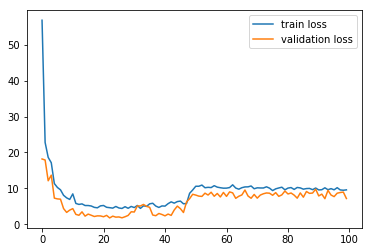

In [ ]:
print(dir(model))

In [ ]:
# print(model.summary())
print(model.weights)
# plt.figure()
# plt.plot(model.summary())